<a href="https://colab.research.google.com/github/wherzberg/Nonlinear_PCA/blob/main/NLPCA_Simulated_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Principle Component Analysis


*   Created by Billy Herzberg
*   william.herzberg@marquette.edu


This notebook will attempt to reproduce Example 1 from *Nonlinear Principle Component Analysis Using Autoassociative Neural Networks* by Kramer (1991). In this example, samples as

```
y1 = 0.8*sin(theta)
y2 = 0.8*cos(theta)
```

where *theta* is uniformly distributed between 0 and 2*pi. There is not a linear relationship between y1 and y2 (which make up coordinates of a circle centerd at the origin and with a radius of 0.8) but NLPCA should be able to pick out a nonlinear factor that best represents the data.

**Or** it can produce a similar example with slightly different parameters for theta, y1, and y2.


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

# Simulate the Data

In [2]:
# Set some hyperparameters
N = 1000    # Use 100 samples
r = 0.8    # radius
r_noise = np.random.normal( loc=0, scale=0.03, size=N)

# Simulate n theta values
theta = np.random.uniform(0,1*math.pi,N) #- math.pi

# Simulate the samples y1 and y2
y1 = r + (r+r_noise)*np.cos(theta)
y2 =     (r+r_noise)*np.sin(theta)

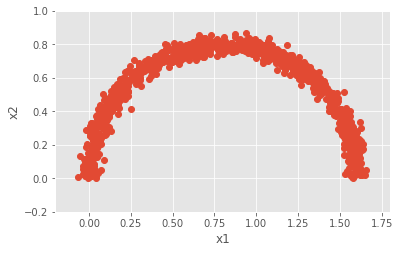

In [3]:
xlim = [-0.2, 1.8]  # Limits for plotting
ylim = [-0.2, 1  ]  # Limits for plotting

# Plot y1 and y2
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(y1,y2,'o')
    plt.xlabel('x1')
    plt.ylabel('x2')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_aspect('equal', 'box')
    axs.grid(True)
    plt.show()

# Make the Encoder/Decoder Model and Train

The neural network model being used for NLPCA can be broken down into two parts:

1.   **Encoder**: This is used to transform the input samples y into the components t. For this example, only one principle component is desired. The Encoder will have an input layer with two nodes (length of each sample) a hidden layer with *M1* nodes, and an output layer with 1 node (length of components).
2.   **Decoder**: This is used to transform the principle components back into the input samples. For this example with only one principle component, the decoder will have one input layer (this is the same as the Encoder's output layer), a hidden layer with *M2* nodes, and an output layer with two nodes (length of each sample).

These two parts are combined into one model for training which means the samples y are used as both input and desired output. The loss function will then be computed as the mean squared error of y and y_pred.



In [4]:
# Sort out the input/output data
y = np.transpose(np.vstack([y1,y2]))
print(y.shape)
split = N*8//10
y_tr = y[      :split , : ]  # Split into training
y_va = y[ split:      , : ]  # and validation data
print(y_tr.shape)
print(y_va.shape)

(1000, 2)
(800, 2)
(200, 2)


In [5]:
# Define the model parameters
ylen = y.shape[1]       # Length of input/output samples
M1 = 4                  # Number of nodes in the encoder hidden layer
M2 = 4                  # Number of nodes in the decoder hidden layer
af = 'tanh'             # Activation function for encoder/decoder hidden layers
init = 'glorot_normal'  # Weight initializer

# Build the model
input = tf.keras.layers.Input( shape=(ylen) )
encoder = tf.keras.layers.Dense(   M1, activation = af,       kernel_initializer=init )(input)
pc      = tf.keras.layers.Dense(    1, activation = 'linear', kernel_initializer=init )(encoder)
decoder = tf.keras.layers.Dense(   M2, activation = af,       kernel_initializer=init )(pc)
output  = tf.keras.layers.Dense( ylen, activation = 'linear', kernel_initializer=init )(decoder)
model   = tf.keras.Model(input,output)

# Display a summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
op = tf.keras.optimizers.Adam( learning_rate = 0.001 )
lo = 'mse'
model.compile(
    optimizer = op,   # Gradient Descent as optimizer
    loss = lo         # Mean Squared Error as loss function : mse(y,y_pred)
)

In [7]:
# Train the model
cb = tf.keras.callbacks.EarlyStopping(
    patience = 100,
    restore_best_weights=True
)

hist = model.fit(
    x = y_tr,                       # input is y
    y = y_tr,                       # desired output is also y
    validation_data = (y_va, y_va),
    batch_size = 5,
    epochs     = 10000,
    verbose    = 0,
    callbacks = cb
)

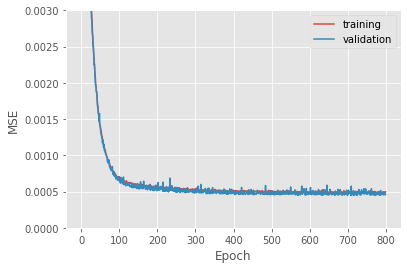

In [8]:
# Plot the training loss
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(hist.history['loss'])
    axs.plot(hist.history['val_loss'])
    axs.set_ylim([0, 0.003])
    axs.legend(['training','validation'])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()

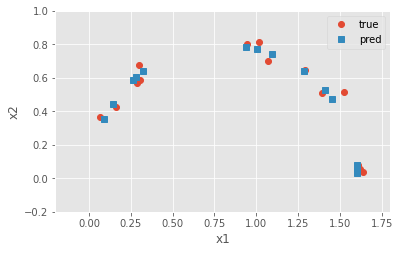

In [9]:
# To really see how it did, plot the true points and the predictions
y_va_pred = model.predict(y_va)
n = 14
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(      y_va[:n,0],      y_va[:n,1], 'o' )
    axs.plot( y_va_pred[:n,0], y_va_pred[:n,1], 's' )
    plt.xlabel('x1')
    plt.ylabel('x2')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_aspect('equal', 'box')
    axs.grid(True)
    axs.legend(['true','pred'])
    plt.show()

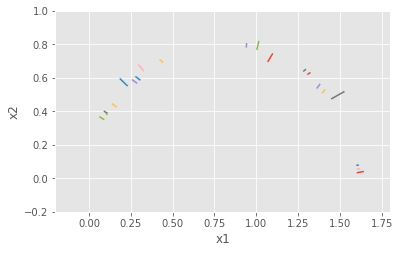

In [10]:
# Or we can draw lines between the true and predicted points
n = 20
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    for i in range(n):
        xx = [ y_va[i,0], y_va_pred[i,0] ]
        yy = [ y_va[i,1], y_va_pred[i,1] ]
        axs.plot(xx,yy)
    plt.xlabel('x1')
    plt.ylabel('x2')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_aspect('equal', 'box')
    axs.grid(True)
    plt.show()

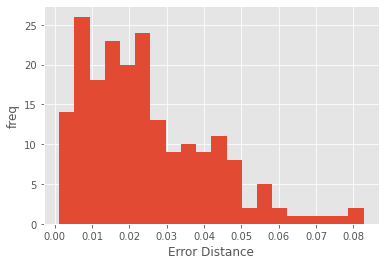

In [11]:
# And finally, we can create a histogram of the lengths of the lines
y_va_pred_er = y_va - y_va_pred
y_va_pred_dist = np.sqrt( np.sum( np.square( y_va_pred_er ), axis=1 ) )
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    plt.hist( y_va_pred_dist, 20 )
    plt.xlabel('Error Distance')
    plt.ylabel('freq')
    axs.grid(True)
    #axs.legend(['true','pred'])
    plt.show()

# Extract the Encoder

After the Encoder/Decoder combined model is trained, the weights in the Encoder can be extracted and placed in a new model that only has the Encoder part. This section will build the new Encoder and set the trained weights.

In [12]:
# Build the Encoder
input = tf.keras.layers.Input( shape=(ylen) )
encoder = tf.keras.layers.Dense(   M1, activation = af   )(input)
pc      = tf.keras.layers.Dense(    1, activation = None )(encoder)
encoder_model = tf.keras.Model(input,pc)

# Display a summary
encoder_model.summary()

# Set the weights from the trained Encoder/Decoder
encoder_model.layers[1].set_weights(model.layers[1].get_weights())
encoder_model.layers[2].set_weights(model.layers[2].get_weights())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


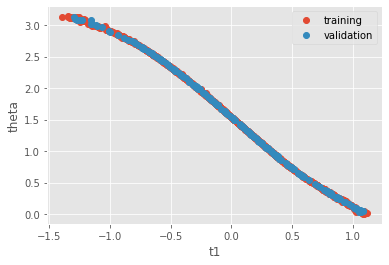

In [13]:
# Predict the using the training and validation data
t_tr_pred = encoder_model.predict(y_tr)
t_va_pred = encoder_model.predict(y_va)

# Adjust theta by something...
theta2 = (theta-0) % (2*math.pi)

# Plot theta and t1
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(t_tr_pred,theta2[:split],'o')
    axs.plot(t_va_pred,theta2[split:],'o')
    plt.xlabel('t1')
    plt.ylabel('theta')
    axs.legend(['training','validation'])
    plt.show()

# Compare to Linear PCA

Linear PCA can also be applied to this data set and we'll see that it doens't perform nearly as well because there isn't a good linear relationship in the data set. We could use a library like sklearn here but instead we'll just do it from scratch!

In [14]:
# Step 1 is to calculate the mean of each feature (y1 and y2) and subtract from 
# y to center the data. Only use the training data here
y_tr_mean = np.mean(y_tr, axis=0)
print(y_tr_mean)
y_tr_cen = y_tr - y_tr_mean
y_va_cen = y_va - y_tr_mean

[0.80354664 0.50649163]


In [15]:
# Step 2 is to compute the covariance of the centered data
COV = np.cov(y_tr_cen.T)
print(COV)

[[0.32691604 0.00408077]
 [0.00408077 0.05945028]]


In [16]:
# Step 3 is computing the eigenvalue (or some other) decomposition of the 
# covariance matrix. Note the eigenvalues are listed in decreasing magnitude
vals, vecs = np.linalg.eig(COV)
print(vecs)
print(vals)

[[ 0.99988368 -0.01525183]
 [ 0.01525183  0.99988368]]
[0.32697828 0.05938803]


In [17]:
# Step 4 is to multiply the eigenvectors by the centered data matrix. This will 
# return a principle components matrix that has the principle components in the 
# columns listed in decreasing order. The number of eigenvectors is the number 
# of principle components being used
num_pcs = 1
T_tr = y_tr_cen @ vecs[:,0:num_pcs]
T_va = y_va_cen @ vecs[:,0:num_pcs]
print(T_tr.shape)
print(T_va.shape)

(800, 1)
(200, 1)


In [18]:
# Step 5 The original data (with some error) can be recovered by multiplying by
# the transpose of the eigenvector matrix
y_tr_pca = T_tr @ vecs[:,0:num_pcs].T + y_tr_mean
y_va_pca = T_va @ vecs[:,0:num_pcs].T + y_tr_mean
print(y_tr_pca.shape)
print(y_va_pca.shape)

(800, 2)
(200, 2)


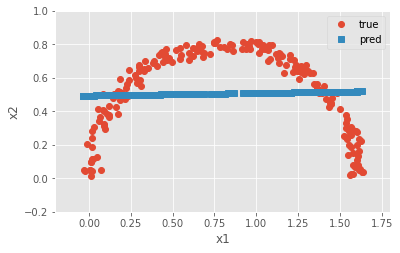

In [19]:
# Ok now we can visualize how it did. How close is y to the y_pca?
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(     y_va[:,0],     y_va[:,1], 'o')
    axs.plot( y_va_pca[:,0], y_va_pca[:,1], 's')
    plt.xlabel('x1')
    plt.ylabel('x2')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_aspect('equal', 'box')
    axs.grid(True)
    axs.legend(['true','pred'])
    plt.show()

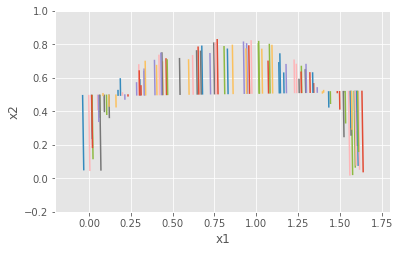

In [24]:
# Or we can draw lines between the true and predicted points (y and y_pca)
n = 100
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    for i in range(n):
        xx = [ y_va[i,0], y_va_pca[i,0] ]
        yy = [ y_va[i,1], y_va_pca[i,1] ]
        axs.plot(xx,yy)
    plt.xlabel('x1')
    plt.ylabel('x2')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.set_aspect('equal', 'box')
    axs.grid(True)
    plt.show()

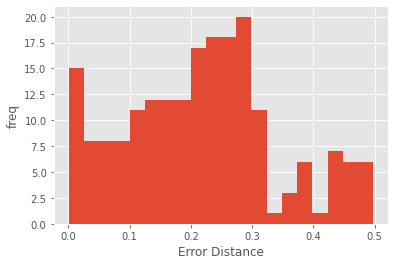

In [21]:
# And finally, we can create a histogram of the lengths of the lines
y_va_pca_er = y_va - y_va_pca
y_va_pca_dist = np.sqrt( np.sum( np.square( y_va_pca_er ), axis=1 ) )
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    plt.hist( y_va_pca_dist, 20 )
    plt.xlabel('Error Distance')
    plt.ylabel('freq')
    axs.grid(True)
    #axs.legend(['true','pred'])
    plt.show()

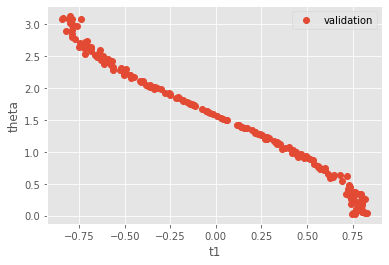

In [25]:
# We can also see if the principle component is associated with theta
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    axs.plot(T_va,theta2[split:],'o')
    plt.xlabel('t1')
    plt.ylabel('theta')
    axs.legend(['validation'])
    plt.show()

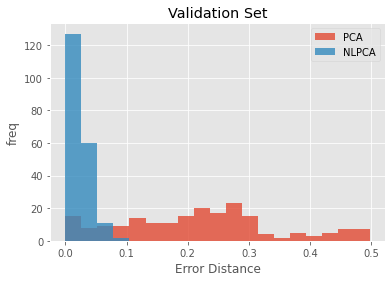

In [23]:
# Compare errors
bins = np.linspace(0, np.max(y_va_pca_dist), num=20)
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1,1)
    plt.hist( y_va_pca_dist,  bins, alpha=0.8 )
    plt.hist( y_va_pred_dist, bins, alpha=0.8 )
    plt.xlabel('Error Distance')
    plt.ylabel('freq')
    plt.title('Validation Set')
    axs.grid(True)
    axs.legend(['PCA','NLPCA'])
    plt.show()